In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.linalg import block_diag

from IPython.display import display, clear_output
from matplotlib.widgets import Slider
from ipywidgets import *
import ipympl

In [2]:
####Class for quadrupole magnets       
class Magnet:
    
    ## When class is created update to create all parameters and store type of class - quadrupole
    # l = length element in meters
    # k = normalised quadrupole strength
    # apt = aperture as list [aperture x, aperture y] in meters
    
    ## Class has class variables of:
    # aperture -> [aperture x, aperture] y in meters
    # elemType -> says this is a quadrupole
    # k -> normalised strength
    # length -> length in meters
    # R -> 6x6 R matrix
    
    def __init__(self, l, k, apt):
        self.update(l, k, apt)
        self.elemType = 'Quadrupole'
        
    ## Update method, creating r matrix and any important class variables
    def update(self, l, k, apt):
        self.aperture = apt
        self.k = k 
        self.length = l
        
        ####if k is greater than 0 then focusing
        if k >0:
            sqrtk = abs(k) ** 0.5
    
            R11 = np.cos(l * sqrtk )
            R12 = sqrtk**-1  * np.sin(l *   sqrtk )
            R21 = -sqrtk  * np.sin(l * sqrtk )
            R22 = np.cos(l * sqrtk )
            R33 = np.cosh(l * sqrtk )
            R34 = sqrtk**-1  * np.sinh(l *   sqrtk )
            R43 = sqrtk  * np.sinh(l *   sqrtk )
            R44 = np.cosh(l *  sqrtk )
        
            self.Rx = np.matrix([[R11, R12], [R21, R22]])
            self.Ry = np.matrix([[R33, R34], [R43, R44]])
            
            self.R = block_diag(self.Rx, self.Ry, np.matrix([[1, 0], [0,1]]))
        
        
        ####if k is less than 0 then defocusing
        elif k < 0:
            sqrtk = abs(k) ** 0.5
            
            R11 = np.cos(l * sqrtk )
            R12 = sqrtk**-1  * np.sin(l *   sqrtk )
            R21 = -sqrtk  * np.sin(l * sqrtk )
            R22 = np.cos(l * sqrtk )
            R33 = np.cosh(l * sqrtk )
            R34 = sqrtk**-1  * np.sinh(l *   sqrtk )
            R43 = sqrtk  * np.sinh(l *   sqrtk )
            R44 = np.cosh(l *  sqrtk )
            
            self.Rx =  np.matrix([[R33, R34], [R43, R44]])
            self.Ry =  np.matrix([[R11, R12], [R21, R22]])
            
            self.R = block_diag(self.Rx, self.Ry, np.matrix([[1, 0], [0,1]]))
        
        ####if k is 0 then drift
        else:
            self.Rx =  np.matrix([[1, l], [0,1]])
            self.Ry =  np.matrix([[1, l], [0,1]])
            
            self.R = block_diag(self.Rx, self.Ry, np.matrix([[1, 0], [0,1]]))
        
    
class Drift:         
    
    ## When class is created update to create all parameters and store type of class - drift
    # l = length element in meters
    
    
    ## Class has class variables of:
    # elemType -> says this is a drift
    # R -> 6x6 R matrix
    
    def __init__(self, l):
        self.update(l)
        self.elemType = 'Drift'
        
    def update(self, l):
        
        self.length = l
        self.Rx =  np.matrix([[1, l], [0,1]])
        self.Ry =  np.matrix([[1, l], [0,1]])
        self.R = block_diag(self.Rx, self.Ry, np.matrix([[1, 0], [0,1]]) )
        
class Collimator:
    
    ## When class is created update to create all parameters and store type of class - collimator
    # l = length element in meters
    # apt = aperture as list [aperture x, aperture y] in meters
    
    ## Class has class variables of:
    # aperture -> [aperture x, aperture] y in meters
    # elemType -> says this is a drift
    # R -> 6x6 R matrix
    
    def __init__(self, l, apt):
        self.update(l, apt)
        self.elemType = 'Collimator'
        
    def update(self, l, apt):
        self.aperture = apt
        self.length = l
        self.Rx =  np.matrix([[1, l], [0,1]])
        self.Ry =  np.matrix([[1, l], [0,1]])
        self.R = block_diag(self.Rx, self.Ry, np.matrix([[1, 0], [0,1]]))     
        
    

class Bend:
    
    ## When class is created update to create all parameters and store type of class - dipole
    # B = bending field used in Tesla
    # lBend = length element in meters
    # momentum = nominal momentum of the beamline in GeV/c
    # apt = aperture as list [aperture x, aperture y] in meters
    # alpha1, alpha2 (optional but both necessary) = angle between beam and magnet face 
    
    ## Class has class variables of:
    # aperture -> [aperture x, aperture] y in meters
    # elemType -> says this is a drift
    # R -> 6x6 R matrix
    
    
    def __init__(self, B, lBend, momentum, apt, alpha1 = None, alpha2 = None):
        
        self.update( B, lBend, momentum, apt, alpha1, alpha2)
        self.elemType = 'Dipole'
    
    ## Calculate the bending radius from momentum and B field
    def getRho(self, B, momentum):
        rho = 3.34 * momentum / B
        return (rho)
        
    ## Calculate how many degrees the particle turns in magnet
    def getTheta(self, lBend, rho, B):
        theta = 2 * np.arctan2(lBend,2 * abs(rho))
        if B>0:
            return(theta)
        elif B<0:
            return(-theta)
        # if B field is 0 return it as something extremely small otherwise we blow up some divisions later
        else:
            return(0.0000000000000001)
            
        
    def update(self, B, lBend, momentum, apt, alpha1 = None, alpha2 = None):
        
        rho = self.getRho(B, momentum)
        theta = self.getTheta(lBend, rho, B)
        
        self.aperture = apt
        self.length = lBend
        
        if alpha1 == None or alpha2 == None:
            alpha1 = theta/2
            alpha2 = theta/2
        
        R11 = np.cos(theta-alpha1)/np.cos(alpha1)
        R12 = rho* np.sin(theta)
        R21 = -1 * (1- np.tan(alpha1)*np.tan(alpha2)) * np.sin(theta - alpha1 - alpha2) / (rho * np.cos(alpha1 + alpha2))
        R22 = np.cos(theta-alpha2)/np.cos(alpha2)
    
        R16 = rho*(1-np.cos(theta))
        R26 =  np.sin(theta) + (1 - np.cos(theta))* np.tan(alpha2)
    
        R33 = 1 - theta* np.tan(alpha1)
        R34 = theta * rho
        R43 = -(np.tan(alpha1) + np.tan(alpha2))/ rho
        R44 = 1 - theta * np.tan(alpha2)
    
    
        Rmat = np.matrix([[R11, R12, 0,   0,   0, R16],
                          [R21, R22, 0,   0,   0, R26],
                          [0,   0,   R33, R34, 0,   0],
                          [0,   0,   R43, R44, 0,   0],
                          [0,   0,   0,   0,   1,   0],
                          [0,   0,   0,   0,   0,   1]])
            
        self.R = Rmat

In [3]:
## From the list of elements we get the R matrix of the whole line
# listElements = list of class of elements in the line
# initialR = initial R matrix of the line -> useful if looking at section of a beamline. Keep none if the line starts with the first element

def MakeLine(listElements, initialR = None):
    
    #If no start then start with an identity
    if initialR is None:
        productR = [ block_diag([[1,0], [0,1]], [[1,0], [0,1]], [[1,0], [0,1]])]
        
    # Else start with starting conditions
    else:
        productR = [initialR]
        
    for i in listElements:
        
        # In the list append the product of the matrices up to that point
        productR.append(i.R.dot(productR[-1])) 
                    
    return(productR)

## Convert from a max gradient to k
def db_to_k(gradient, momentum):
    k = gradient * 0.2998 / momentum
    return(k)



## Get the position of the end of each element
# listElements = list of class of elements in the line

def GetPositions(listElements):
    positions = [0]
    
    # Go through element by element, adding the length of the element to the length of the line up to the previous point
    for i in listElements:
        positions.append(positions[-1] + i.length)
    
    return(np.asarray(positions))

## Pull out the i,j th elements of the R matrix at each point 
# (e,g  ExtractElement(productR, 1, 2) will return an array with the R12 at each point in the line)

def ExtractElement(productR, i, j):
    elementList = []
    for elem in productR:
        elementList.append(elem[i-1, j-1])
        
    return(np.asarray(elementList))

In [4]:
#Return the variables we are interested in plotting:
#listElements = list of class of elements in the line
# initialR = initial R matrix of the line -> useful if looking at section of a beamline. Keep none if the line starts with the first element

# zPos -> Array of positions of end of each element
# R11, R12, R33. R34 -> array of that r matrix at each position

def GetPlottables(listElements, initialR = None):
    productR = MakeLine(listElements, initialR = initialR)
    zPos  = GetPositions(listElements)
    
    R11 = ExtractElement(productR, 1, 1)
    R12 = ExtractElement(productR, 1, 2)
    R33 = ExtractElement(productR, 3, 3)
    R34 = ExtractElement(productR, 3, 4)
    
    return(zPos, R11, R12, R33, R34)


### Plot the R matrices from a list of elements and a starting condition, returns all things going into the plot
# listElements = list of class of elements in the line
# initialR = initial R matrix of the line -> useful if looking at section of a beamline. Keep none if the line starts with the first element

# returns all the important parts of the plot:
# fig -> fig of the plot
# axs -> list of 4 axes  [x_ax, y_ax, ps_x_ax, ps_y_ax] in first 2 axs there are the R matrices in x and y. In the second 2 axs 
# there is the accepted phase space of the line in x and y respectively
# plots -> list of all the plots going into the axs
# patches -> [patchesX, patchesY] : List of list of patches used in the plots to rapresent the elements in the x, y R matrix plots


# Returns a list of [aptx, apty] for each element (returns a list of lists)
# listElements = list of class of elements in the line

#apertureList -> list of [apt x, apt y] in meters for each element. Drifts/ elements without aperture values take the value of aperture of the next element with an aperture
def GetApertures(listElements):
    
    apertureList = []
    
    # A counter for number of time we need to add a certain aperture
    repeat = 1
    
    for elem in listElements:
        # if the element in the list has the attribute aperture, append it as many times as necessary
        if hasattr(elem, 'aperture'):
            for i in range(repeat):
                apertureList.append(elem.aperture)
            repeat = 1
            
        else: ###If there isnt an aperture we append the next aperture several times, + 1 for each element without an aperture
            repeat += 1
        
    if repeat != 1: ###If we ended with some drifts these will not have a max aperture, meaning one will have to be added
        for i in range(repeat):
            apertureList.append([999999999999, 999999999999])
            
    return(apertureList)


def PlotRMatrixAndAcceptance(listElements, initialR = None):
    
    productR = MakeLine(listElements, initialR = initialR)
    
    fig, ((x_ax, y_ax), (ps_x_ax, ps_y_ax)) = plt.subplots(2,2)

    zPos, R11, R12, R33, R34 = GetPlottables(listElements, initialR = initialR)
    RList = [R11, R12, R33, R34]
    
    
    #Pick limits for the plots, the hightes element between R11, R12, R33 and R34 rounded up to the next multuple of 5
    lims = max(max(abs(R11)), max(abs(R12)), max(abs(R33)), max(abs(R34)))
    lims = min((lims + 5) // 5 * 5, 200)

    #Focus on x axis
    plt.axes(x_ax)
    #Plot R11, R12 and return those 2 plots
    R11Plot, R12Plot = NicePlot(zPos, R11, R12, lims, ['R11', 'R12'])
    #Plot and return the elements in the x plane
    patchesX = PlotElements(listElements, zPos, x_ax, lims, 0 )
        
        
    #Focus on y axis
    plt.axes(y_ax)
    #Plot R33, R34 and return those 2 plots
    R33Plot, R34Plot = NicePlot(zPos, R33, R34, lims, ['R33', 'R34'])
    #Plot and return the elements in the y plane
    patchesY = PlotElements(listElements, zPos, y_ax, lims, 1 )
    
    #Plot the phase space in x, y return the axs and the line plots 
    ps_x_ax, ps_y_ax, PSxPlots, PSyPlots = PlotAcceptedPhaseSpace(RList, listElements, ps_x_ax, ps_y_ax)
    
    
    # Put all axs in a list to return them
    axs =  [x_ax, y_ax, ps_x_ax, ps_y_ax]
    # Put all plots in a list to return them
    plots = [R11Plot, R12Plot, R33Plot, R34Plot, PSxPlots, PSyPlots]
    # Put all patches in a list to return them
    patches = [patchesX, patchesY]
    
    return(fig, axs, plots, patches)


### Updates the R matrices and phase space plots from the same of elements, starting condition, and THE SAME fig, axs, plots, patches
# created bu PlotRMatrixAndAcceptance.
# listElements = list of class of elements in the line
# initialR = initial R matrix of the line -> useful if looking at section of a beamline. Keep none if the line starts with the first element
# fig = fig of the plot
# axs = list of 4 axes  [x_ax, y_ax, ps_x_ax, ps_y_ax] in first 2 axs there are the R matrices in x and y. In the second 2 axs 
# there is the accepted phase space of the line in x and y respectively
# plots = list of all the plots going into the axs
# patches = [patchesX, patchesY] : List of list of patches used in the plots to rapresent the elements in the x, y R matrix plots

def UpdatePlot(fig, axs, plots, patches, listElements, initialR = None, UpdateLimits = True):
    
    #Gets new R elements and extracts them as before
    zPos, R11, R12, R33, R34 = GetPlottables(listElements, initialR = initialR)
    RList = [R11, R12, R33, R34]
    
    #Calculates new limits
    if UpdateLimits:
        lims = max(max(abs(R11)), max(abs(R12)), max(abs(R33)), max(abs(R34)))
        lims = min((lims + 5) // 5 * 5, 200)
    
    #Sets new limits
    axs[0].set_ylim(-lims, lims)
    axs[1].set_ylim(-lims, lims)
    axs[0].set_xlim(0, max((zPos + 5) // 5 *5))
    axs[1].set_xlim(0, max((zPos + 5) // 5 *5))
    
    #Sets new x, y values of the R matrices
    # Indeces are from the fact that in PlotRMatrixAndAcceptance we stored in 'plots' in the order R11, R12, R33, R34
    plots[0].set_ydata(R11)
    plots[0].set_xdata(zPos)
    plots[1].set_ydata(R12)
    plots[1].set_xdata(zPos)
    
    plots[2].set_ydata(R33)
    plots[2].set_xdata(zPos)
    plots[3].set_ydata(R34)
    plots[3].set_xdata(zPos)
    
    #Updates the Phase space plots
    UpdatePSPlots(axs[2], axs[3], plots[4], plots[5], listElements, RList)
    
    # Updates the position of the patches of the elements in the line
    UpdateElementPatchPlot(patches[0], listElements, zPos, lims, 0)        
    UpdateElementPatchPlot(patches[1], listElements, zPos, lims, 1)
    

In [5]:
### Plots the phase space which is accepted by a beamline given by elementList with r matrices given by Rlist in ax1 for x plane and ax2 for y plane
# RList = list of R matrices of beamline
# listElements = list of class of elements in the line
# ax1 = ax where accepted phase space in x will be plotted 
# ax2 = ax where accepted phase space in y will be plotted 

#returns:
# ax1 -> modified ax in x
# ax2 -> modified ax in y
# PSxPlot -> plot for the phase space in x
# PSxPlot -> plot for the phase space in y

def PlotAcceptedPhaseSpace(RList, elementList, ax1, ax2):

    # Extract the apertures of all the elements in the beamline
    apertureList = GetApertures(elementList)
    
    # The distance in x over which we are looking at in meters, and we set y to be the same
    xvar = np.linspace(-0.1, 0.1, 401)
    yvar = xvar
    xpmaxvar = []
    xpminvar = []
    ypmaxvar = []
    ypminvar = []
    
    # For each one of those starting points we calculate max and minimum x' and y' which are accepted by the line and add them to a list
    for x in xvar:
        xpmax, xpmin, ypmax, ypmin = CalculatePrimeLimits(RList, x, apertureList)
        xpmaxvar.append(xpmax)
        xpminvar.append(xpmin)
        ypmaxvar.append(ypmax)
        ypminvar.append(ypmin)

    #convert those lists to array
    xpmaxvar = np.asarray(xpmaxvar) 
    xpminvar = np.asarray(xpminvar) 
    ypmaxvar = np.asarray(ypmaxvar) 
    ypminvar = np.asarray(ypminvar) 

    # keep points in those lists where the accepted max is greater than the accepted min
    xpmaxvarNew = xpmaxvar[(xpmaxvar >= xpminvar)] 
    xpminvarNew = xpminvar[(xpmaxvar >= xpminvar)] 
    ypmaxvarNew = ypmaxvar[(ypmaxvar >= ypminvar)]
    ypminvarNew = ypminvar[(ypmaxvar >= ypminvar)] 

    xvarNew = xvar[(xpmaxvar >= xpminvar)]
    yvarNew = yvar[(ypmaxvar >= ypminvar)]

    # Plot these lines in the correct ax and shade
    ax1, ax2, PSxPlot, PSyPlot = PhaseSpace(xvarNew, xpmaxvarNew, xpminvarNew, yvarNew, ypmaxvarNew, ypminvarNew, ax1, ax2)
    
    
    return(ax1, ax2, PSxPlot, PSyPlot)
 
    

### Plots the phase space which is accepted by a beamline given by elementList with r matrices given by Rlist in ax1 for x plane and ax2 for y plane
# x = list of points in x which are accepted in meters
# xpMax = list of largest angle accepted at each x in x list
# xpMin = list of smallest angle accepted at each x in x list
# y = list of points in y which are accepted in meters
# ypMax = list of largest angle accepted at each y in y list
# ypMin = list of smallest angle accepted at each y in y list
# ax1 = ax where accepted phase space in x will be plotted 
# ax2 = ax where accepted phase space in y will be plotted 

#returns:
# ax1 -> modified ax in x
# ax2 -> modified ax in y
# PSxPlot -> plot for the phase space in x
# PSxPlot -> plot for the phase space in y

def PhaseSpace(x, xpMax, xpMin, y, ypMax, ypMin, ax1, ax2):
    
    #All * 1000 is to convert to mm
    
    # Go to x plot
    plt.axes(ax1)
    upperX, = plt.plot(x*1000, xpMax*1000, color = 'blue')
    lowerX, = plt.plot(x*1000, xpMin*1000, color = 'blue')
    # Shade area between two plots
    plt.fill_between(x*1000, xpMax*1000, xpMin*1000, color = 'blue', alpha = 0.5 )
    
    plt.grid()
    plt.xlim(-0.03*1000, 0.03*1000)
    plt.xlabel('x [mm]')
    plt.ylim(-0.03*1000, 0.03*1000)
    plt.ylabel("x' [mrad]")
    
    # Go to x plot
    plt.axes(ax2)
    upperY, = plt.plot(y*1000, ypMax*1000, color = 'blue')
    lowerY, = plt.plot(y*1000, ypMin*1000, color = 'blue')
    # Shade area between two plots
    plt.fill_between(y*1000, ypMin*1000, ypMax*1000, color = 'blue', alpha = 0.5)
    
    plt.grid()
    plt.xlim(-0.03*1000, 0.03*1000)
    plt.xlabel('y [mm]')
    plt.ylim(-0.03*1000, 0.03*1000)
    plt.ylabel("y' [mrad]")
    
    PSxPlot = [upperX, lowerX]
    PSyPlot = [upperY, lowerY]
    
    return(ax1, ax2, PSxPlot, PSyPlot)
    

# Calculates the maximum and minimum x prime (or y prime) accepted at each position in space by a beamline at the start of it
# RList = list of R matrices of beamline
# x = position we are looking at at the start of the beamline 
# apertureList = list of apertures of elements in beamline in form [aptx, apty]

# returns:
# xp1 max x' accepted for particle starting at x 
# xp2 min  x' accepted for particle starting at x
# yp1 max y' accepted for particle starting at x
# yp1 min y' accepted for particle starting at x

#since we are looking at a target where there is no difference in x and y before starting the beamline we can cheat a bit and call x and y the same thing
#as long as we save the results to different variables

def CalculatePrimeLimits(RList, x, apertureList):
    
    R11s = RList[0][1:] 
    R12s = RList[1][1:] 
    R33s = RList[2][1:] 
    R34s = RList[3][1:]
    
    #create lists of max and min values particles can have
    upperBoundX = []
    lowerBoundX = []
    upperBoundY = []
    lowerBoundY = []
    
    
    #Loop over each R matrix element and the aperture at that point. (Both defined at the end of the element)
    # take aperture list from second element as that is where the end of the first element is. apertureList[0] is either an identity or the initial distribution 
    for R11, R12, R33, R34, aperture in zip(R11s, R12s, R33s, R34s, apertureList[1:]):
        
        aperturex = aperture[0]
        aperturey = aperture[1]
        
        #Work out the angle a particle at a given x has to have to reach the aperture at either the top (+) or bottom (-) of the element
        xppos = (aperturex  - R11 * x)/ R12
        xpneg = (-aperturex - R11 * x)/ R12        
        yppos = (aperturey  - R33 * x)/ R34
        ypneg = (-aperturey - R33 * x)/ R34
        
        
        #If R12 is positive an increase in x' leads to an increase in the final x (ie Xf = x*R11 + x'*R12 so dXf =  R12*dx'), so x' calculated here will be the largest possible x' at that pos
        #(and vice versa for -, where x' will be the smallest possible angle)
        
        if R12>0:
            upperBoundX.append(xppos)
            lowerBoundX.append(xpneg)            
        #If R12 is negative however, an increase in x' will lead to a decrease of Xf, meaning that at +aperture the angle is actually the smallest acceptable angle and vice versa fot -aperture  
        elif R12<0:
            lowerBoundX.append(xppos)
            upperBoundX.append(xpneg)
        else: 
            continue
            
            
        if R34>0:
            upperBoundY.append(yppos)
            lowerBoundY.append(ypneg)            
        #If R12 is negative however, an increase in x' will lead to a decrease of Xf, meaning that at +aperture the angle is actually the smallest acceptable angle and vice versa fot -aperture  
        elif R34<0:
            lowerBoundY.append(yppos)
            upperBoundY.append(ypneg)
        else: 
            continue
    
    
    #Take the smallest of the largest angles as this will be what imposes the limit and the same by taking the max of the lower bounds
    xp1 = min(upperBoundX)
    xp2 = max(lowerBoundX)
    
    yp1 = min(upperBoundY)
    yp2 = max(lowerBoundY)
    
    #Returns maximum and minimum x'
    
    #NOTE: There is no guarantee that xpMax is > xpMin, and actually there will always be a cross over point. All this means is that the acceptance from that x is 0 -- no angles can make it between
    # +A and -A
    return(xp1, xp2, yp1, yp2)
    
    



def FindArea(diffX, diffY):
    
    #As arguments we have the differences between x'Max and x'Min, meaning that if x'Max > x'Min then entry is positive
    #Cut out the negative parts of the distributions and integrate the leftover, ie only the area between xpMax and min
    #Note the dx = 1e-3 is because the sampling of the points was every one mm - if this changes this will have to change too.
    
    posPartX = np.maximum(diffX, 0)
    areaX = np.trapz(posPartX, dx=1e-3)
    
    posPartY = np.maximum(diffY, 0)
    areaY = np.trapz(posPartY, dx=1e-3)
    
    return(areaX, areaY)



### Updates the phase space which is accepted by a beamline given by elementList with r matrices given by Rlist 
# RList = list of R matrices of beamline
# listElements = list of class of elements in the line
# axPSX = ax in x
# axPSY = ax in y
# plotsX = plot for the phase space in x
# plotsY = plot for the phase space in y

def UpdatePSPlots(axPSX, axPSY, plotsX, plotsY, listElements, RList):
    
    # Get the apertures for each element in the line
    apertureList = GetApertures(listElements)
    
    # The distance in x over which we are looking at in meters, and we set y to be the same
    xvar = np.linspace(-0.1, 0.1, 401)
    yvar = xvar
    xpmaxvar = []
    xpminvar = []
    ypmaxvar = []
    ypminvar = []
    
    # For each one of those starting points we calculate max and minimum x' and y' which are accepted by the line and add them to a list
    for x in xvar:
        xpmax, xpmin, ypmax, ypmin = CalculatePrimeLimits(RList, x, apertureList)
        xpmaxvar.append(xpmax)
        xpminvar.append(xpmin)
        ypmaxvar.append(ypmax)
        ypminvar.append(ypmin)

    # convert those lists to array
    xpmaxvar = np.asarray(xpmaxvar) 
    xpminvar = np.asarray(xpminvar) 
    ypmaxvar = np.asarray(ypmaxvar) 
    ypminvar = np.asarray(ypminvar) 
    
    # keep points in those lists where the accepted max is greater than the accepted min
    xpmaxvarNew = xpmaxvar[(xpmaxvar >= xpminvar)] 
    xpminvarNew = xpminvar[(xpmaxvar >= xpminvar)] 
    ypmaxvarNew = ypmaxvar[(ypmaxvar >= ypminvar)]
    ypminvarNew = ypminvar[(ypmaxvar >= ypminvar)] 
    
    xvarNew = xvar[(xpmaxvar >= xpminvar)]
    yvarNew = yvar[(ypmaxvar >= ypminvar)]
    
    # Clear the previous shaded region showing the accepted phase space
    axPSX.collections.clear()
    axPSY.collections.clear()
    
    
    # Shade between the curves, remembering to convert to mm
    axPSX.fill_between(xvarNew*1000, xpminvarNew*1000, xpmaxvarNew*1000, color = 'blue', alpha = 0.5)
    axPSY.fill_between(yvarNew*1000, ypminvarNew*1000, ypmaxvarNew*1000, color = 'blue', alpha = 0.5)
    
    # Set new x and y datas
    plotsX[0].set_data(xvarNew*1000, xpmaxvarNew*1000)
    plotsX[1].set_data(xvarNew*1000, xpminvarNew*1000)
    
    plotsY[0].set_data(yvarNew*1000, ypmaxvarNew*1000)
    plotsY[1].set_data(yvarNew*1000, ypminvarNew*1000)
    
    diffX = xpmaxvar - xpminvar
    diffY = ypmaxvar - ypminvar
    
    #Print the accepted phase spaces
    Ax, Ay = FindArea(diffX, diffY)
    print('Phase space area X = %2.1f mm mrad\nPhase space area Y = %2.1f mm mrad\nTotal is %2.1f mm mrad' %(Ax * 10**6, Ay* 10**6, (Ax+Ay)* 10**6))

In [6]:
### Plots the sine like and cosine like elements for a beamline
# zPos = position of end of each element in meters
# cosLike =  list of R11 or R33 elements for line
# cosLike =  list of R12 or R34 elements for line
# lims = list of limits of plots
# labels = list of labels used [sin label, cos label]

# returns:
# sinPlot -> plot (y vals) for the sin like term
# sinPlot -> plot (y vals) for the cos like term

def NicePlot(zPos, cosLike, sinLike, lims, labels):
    
    #store only the y values of the plot by not naming second argument in next 2 lines
    sinPlot, = plt.plot(zPos, cosLike, '-g', label = labels[0])
    cosPlot, = plt.plot(zPos, sinLike, '-r', label = labels[1])
    plt.grid()
    plt.legend()
    plt.ylim(-lims, lims)
    plt.xlim(0)
    return(sinPlot, cosPlot)
     
    
### Plots the patch for each element 
# listElements = list of class of elements in the line
# zPos = position of end of each element in meters
# ax = the ax in which we are working
# lims = the lims of the plot
# planeID = 0 for horizontal (x) plane, 1 for vertical (y) plane, picks the element in the aperture [apt x, apt y]

# returns:
# patchesList -> list of patches which have been plotted and may need to be changed

def PlotElements(listElements, zPos, ax, lims, planeID ):
    patchesList = []
    
    # Go through each element and check which type it is 
    for i in range(0, len(listElements)):
        
        #Check if its a quad
        if listElements[i].elemType == 'Quadrupole':
            #plot a patch in ax above and below the x axis leaving the space of the aperture. Then append to list of patches
            height = listElements[i].aperture[planeID]
            ptch = Rectangle((zPos[i],  height/2), listElements[i].length, lims - height/2, alpha = 0.5, color = 'blue')
            patchesList.append(ptch)
            ax.add_patch(ptch)
            ptch = Rectangle((zPos[i],  -lims), listElements[i].length, lims - height/2, alpha = 0.5, color = 'blue')
            patchesList.append(ptch)
            ax.add_patch(ptch)
            
        #Check if its a dipole
        if listElements[i].elemType == 'Dipole':
            #plot a patch in ax above and below the x axis leaving the space of the aperture. Then append to list of patches
            height = listElements[i].aperture[planeID]
            ptch = Rectangle((zPos[i],  height/2), listElements[i].length, lims - height/2, alpha = 0.5, color = 'green')
            patchesList.append(ptch)
            ax.add_patch(ptch)
            ptch = Rectangle((zPos[i],  -lims), listElements[i].length, lims - height/2, alpha = 0.5, color = 'green')
            patchesList.append(ptch)
            ax.add_patch(ptch)
        
        #Check if its a collimator
        if listElements[i].elemType == 'Collimator':
            #plot a patch in ax above and below the x axis leaving the space of the aperture. Then append to list of patches
            height = listElements[i].aperture[planeID]
            ptch = Rectangle((zPos[i],  height/2), listElements[i].length, lims - height/2, alpha = 0.5, color = 'orange')
            patchesList.append(ptch)
            ax.add_patch(ptch)
            ptch = Rectangle((zPos[i],  -lims), listElements[i].length, lims - height/2, alpha = 0.5, color = 'orange')
            patchesList.append(ptch)
            ax.add_patch(ptch)
            
    return(patchesList)      
    
    
    
### Updates the patches to be in the correct new position
# patchesList = list of patches which have been plotted and may need to be changed
# listElements = list of class of elements in the line
# zPos = position of end of each element in meters
# lims = the lims of the plot
# planeID = 0 for horizontal (x) plane, 1 for vertical (y) plane, picks the element in the aperture [apt x, apt y]

def UpdateElementPatchPlot(patchesList, listElements, zPos, lims, planeID):
    k = 0
    #Go through each element, redraw each element and since we are drawing 2 patches per element then check elements in patches list 2 elements after
    for i in range(0, len(listElements)):
        if listElements[i].elemType in ['Quadrupole' , 'Dipole', 'Collimator'] :
            height = listElements[i].aperture[planeID]
            
            patchesList[k].set_x(zPos[i])
            patchesList[k].set_y(height/2)
            patchesList[k].set_height(lims- height/2 )
            patchesList[k].set_width(listElements[i].length)
            
            patchesList[k+1].set_x(zPos[i])
            patchesList[k+1].set_y(-lims)
            patchesList[k+1].set_height(lims - height/2 )
            patchesList[k+1].set_width(listElements[i].length)
            k+=2
        

        
def updater(initialR = None, UpdateLimits = True):
    UpdatePlot(fig, axs, plots, patches, listElements, initialR, UpdateLimits)
    fig.canvas.draw_idle()

<IPython.core.display.Javascript object>


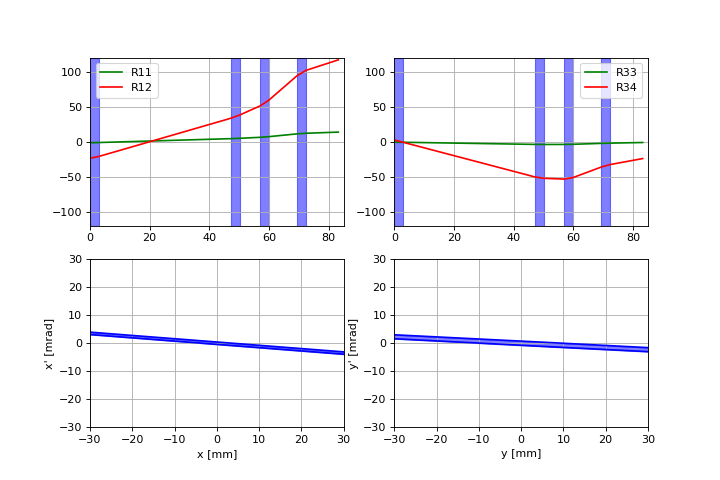

interactive(children=(FloatSlider(value=-5.18, description='gl1', max=74.75, min=-74.75, step=0.2), FloatSlide…

In [10]:
####Example 1: tuning h2 optics


%matplotlib widget
plt.rcParams["figure.figsize"] = (9,6)


# Nominal momentum of H2 line we are looking at
momentum = 400
    
# R matrices before what we are interested in tuning 

R11s = -1.632  #-1.206 
R12s = -23.757  #-23.419 
R21s = 0.075   #0.040  
R22s = 0.472    #-0.047 
R33s =  -0.793   #-1.019 
R34s =2.330     #-8.439  
R43s = -0.040    #-0.021 
R44s = -1.143   #-1.157



### Put these in an R matrix
initialR = np.matrix([[R11s, R12s, 0,     0],
                      [R21s, R22s, 0,     0],
                      [0,    0,    R33s,  R34s], 
                      [0,    0,    R43s,  R44s]])
initialR = block_diag(initialR, [[1,0], [0,1]])
    

#length of qnl magnet and qwl magnet
lqnl = 2.99
lqwl = 2.948

#starting gl given by TRANSPORT
gl1fit = -5.18
gl2fit = -54.016
gl3fit = -36.34
gl4fit = 58.83

# Converted to normalised strength
k1fit = db_to_k(gl1fit / lqnl, momentum)
k2fit = db_to_k(gl2fit / lqnl, momentum)
k3fit = db_to_k(gl3fit / lqwl, momentum)
k4fit = db_to_k(gl4fit / lqwl, momentum)


# for each element create a magnet, drift etc class with the correct parameters

m1 = Magnet(lqnl, k1fit, [0.05, 0.05])
d1 = Drift(44.175)

m2 = Magnet(lqnl, k2fit, [0.05, 0.05])
d2 = Drift(6.78)

m3 = Magnet(lqwl, k3fit, [0.04, 0.04])
d3 = Drift(9.52)

m4 = Magnet(lqwl, k4fit, [0.04, 0.04])
d4 = Drift(10.86)


# put the elements in a list representing the beamline
listElements = [ m1, d1, m2, d2, m3, d3, m4, d4]

# Plot this configuration
fig, axs, plots, patches = PlotRMatrixAndAcceptance(listElements, initialR=initialR)

# max gradients from magnet guide
maxg1 = 25 
maxg2 = 25
maxg3 = 20
maxg4 = 20


# create a slider widget for each gradient
# in slider we define the name of the variable we want to slide, the max and min of the slider and the step
# eg gl1 is name, goes from "-maxg1* m1.length" to "-maxg1* m1.length" in steps of 0.2
# in the functon UpdateParameters, by setting default values of a variable, a starting position in the slider is picked
@interact(gl1=(-maxg1* m1.length, maxg1* m1.length, 0.2) , 
          gl2=(-maxg2* m2.length, maxg2* m2.length, 0.2), 
          gl3=(-maxg3* m3.length, maxg3* m3.length, 0.2),
          gl4=(-maxg4* m4.length, maxg4* m4.length, 0.2)          
         )
def UpdateParameters(gl1 = gl1fit, 
                     gl2 = gl2fit, 
                     gl3 = gl3fit,
                     gl4 = gl4fit):
    # From a new gl we get a new k1
    # Update the desired magnet with it
    k1 = db_to_k(gl1/m1.length, momentum)
    m1.update(m1.length, k1, m1.aperture)
    
    k2 = db_to_k(gl2/m2.length, momentum)
    m2.update(m2.length, k2, m2.aperture)
    
    k3 = db_to_k(gl3/m3.length, momentum)
    m3.update(m3.length, k3, m3.aperture)
    
    k4 = db_to_k(gl4/m4.length, momentum)
    m4.update(m4.length, k4, m4.aperture)

    # Run updater 
    updater(initialR)
    
    
#As we are modifying the properties of a class, we do not need to modify the listElements variable, all important things are already changed autmatically in the background